# ACCESS-OM3 SST and SST difference from WOA23

Related issue: https://github.com/ACCESS-Community-Hub/access-om3-25km-paper-1/issues/9

In [1]:
#This cell must be in all notebooks!
#It allows us to run all the notebooks at once, this cell has a tag "parameters" which allows us to pass in 
# arguments externally using papermill (see mkfigs.sh for details)

### USER EDIT start
esm_file='/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json
Plot folder path:  /g/data/g40/jj8842/access-om3-paper-figs/


In [2]:
import xarray as xr
import cf_xarray
import warnings
warnings.simplefilter('ignore')
import intake
import numpy as np
import cftime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from textwrap import wrap
from distributed import Client

In [3]:
client = Client(threads_per_worker=1)
client

<Client: 'tcp://127.0.0.1:39573' processes=7 threads=7, memory=32.00 GiB>

### Define plot function

In [4]:
blue_marble = plt.imread('/g/data/ik11/grids/BlueMarble.tiff')
blue_marble_extent = (-180, 180, -90, 90)

In [5]:
def plot(dat, title=None, **kwargs):
    if title is None:
        title = dat.attrs['long_name']
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    dat.plot.contourf(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={"label": "\n".join(wrap(f"{dat.attrs['long_name']} [{dat.attrs['units']}]", 45)),
                     "fraction": 0.03, "aspect": 15, "shrink": 0.7},
        **kwargs
    )
    
    # Add blue marble land:
    ax.imshow(
        blue_marble, extent=blue_marble_extent, transform=ccrs.PlateCarree(), origin="upper"
    )
    
    plt.title(title);

## Define 20° isotherm function

In [6]:
def interpolate_isotherm_depth(temp, target_temp, depth_name):
    """ 
        Interpolates between the deepest point warmer than target_temp 
        and the next deepest point to return isotherm depth

        Parameters
        ----------
        temp : xr.DataArray
            N-dimensional ocean temperature, where depth is one dimension
            CMIP name would be thetao
        target_temp: scalar
            temperature of isotherm being calculated
        depth_name: str
            name of xarray dimension on temp containing depth

        Returns
        -------
        xr.DataArray
            isotherm depth, same shape as temp but with the depth coordinate collapsed

        Notes
        -----
        Anywhere the surface (first depth) value is NaN returns a NaN
        Anywhere that the entire water collumn is colder than target_temp returns a zero
        Anywhere that the entire water collumn is warmer than target_temp returns an 
            interpolation between the deepest layer and the next one down
        Poorly defined if the isotherm hits the bottom of the grid, but I can't see that
            happening in a reasonable situation, will throw errors
    """    
    assert np.all(np.logical_not(temp[depth_name]<0)), 'depths should all be positive'
    assert np.all(np.logical_not(temp[depth_name].diff(depth_name)<=0)), 'depths should be monotonically increasing'
    
    temp = temp.load() # Unfortunately, where doesn't work with lazy data

    # Manage any NaNs coming in
    # In this case and the next, "manage" means fill with dummy values I know will work, 
    # and then replace them all later
    originally_nan = np.isnan(temp.isel({depth_name:0})) #Probably land - any lat/lon where the surface is a NaN
    temp = temp.where(np.logical_not(originally_nan)| (temp[depth_name]>temp[depth_name][0]),target_temp+0.1) # If NaN, reset top to just above isotherm
    temp = temp.where(np.logical_not(originally_nan) | (temp[depth_name]!=temp[depth_name][1]),target_temp-0.1) #If NaN, 2nd level to just below isotherm

    # Manage any locations which don't have an appropriate isotherm (never above target_temp)
    isotherm_outcrops = (temp.max(depth_name)<target_temp)
    temp = temp.where(np.logical_not(isotherm_outcrops) | (temp[depth_name]>temp[depth_name][0]),target_temp+0.1) # If it outcrops, reset top to 20.1

    # Find deepest point above target temperature
    i0 = (temp[depth_name].where(temp>=target_temp)          # Depth where warmer than target
         ).argmax(dim=depth_name).compute()                 # Find deepest index

    assert np.all(i0<(temp[depth_name].shape[0]-1)), 'bottom cell is above target_temp, not designed to handle this condition'

    # Depth immediately below isotherm
    i1 = i0+1

    t0 = temp.isel({depth_name:i0})             # temperature above isotherm
    z0 = temp[depth_name].isel({depth_name:i0}) # depth above isotherm

    t1 = temp.isel({depth_name:i1})             # temperature below isotherm
    z1 = temp[depth_name].isel({depth_name:i1}) # depth below isotherm

    # Manage any locations where z0 is just on top of bathymetry
    isotherm_hits_bathymetry = np.isnan(t1)

    isotherm_depth = (target_temp-t0)*(z0-z1)/(t0-t1)+z0 # Linear interpolation, from rearranging (y-y0) = m(x-x0)

    # Add back in all of our caveats (in order of increasing priority)
    isotherm_depth = isotherm_depth.where(np.logical_not(isotherm_hits_bathymetry),(z0+z1)/2)
    isotherm_depth = isotherm_depth.where(np.logical_not(isotherm_outcrops),0)
    isotherm_depth = isotherm_depth.where(np.logical_not(originally_nan))
    
    
    return isotherm_depth

### Load and plot data from ACCESS-OM3

In [7]:
exptname=os.path.basename(os.path.dirname(esm_file))

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [8]:
exptname

'25km-iaf-test-for-AK-expt-7df5ef4c'

In [9]:
geolon = datastore.search(variable="geolon").to_dask().geolon
geolat = datastore.search(variable="geolat").to_dask().geolat

In [10]:
variable = "temp"
level_name = 'z_l' # Anticipate this changing as we switch to more CMORised names

model_all = datastore.search(variable=variable, frequency="1mon").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time":-1, #may as well
                #'yh':-1, # necessary for map_blocks, whcih doesn't like the variable chunk sizes from AK's trim-off-the-top
                level_name:-1 # necessary to get accurate answers out of map_blocks
               },
        decode_timedelta=True
    ),
    xarray_combine_by_coords_kwargs=dict(
        compat="override",
        data_vars="minimal",
        coords="minimal"
    )
)[variable].cf.assign_coords({ "longitude": geolon, "latitude": geolat })

In [11]:
##### ONLY NEEDED FOR 25km-iaf-test-for-AK-expt-7df5ef4c !!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# omit latitudes with grid bug https://github.com/ACCESS-NRI/ocean_model_grid_generator/issues/7
model_all = model_all.isel(yh=slice(10, None))
geolon = geolon.isel(yh=slice(10, None))
geolat = geolat.isel(yh=slice(10, None))

In [12]:
# for IAF
model_all = model_all.convert_calendar("proleptic_gregorian", use_cftime=True)
print(model_all.time.values[0]) # initial date in data
print(model_all.time.values[-1]) # final date in data

datestop = cftime.DatetimeProlepticGregorian(2018, 12, 14, 12, 0, 0, 0, has_year_zero=True)  # to match OM2 IAF run
datelist = list(cftime.to_tuple(datestop))
datelist[0] -= 10  # last 10 years
datestart = cftime.datetime(*datelist, calendar=datestop.calendar)
timerange = slice(datestart, datestop)

model_all = model_all.sel(time=timerange)
model_all

1958-01-16 12:00:00
2023-12-16 12:00:00


<xarray.DataArray 'temp' (time: 120, z_l: 75, yh: 1142, xh: 1440)> Size: 59GB
dask.array<getitem, shape=(120, 75, 1142, 1440), dtype=float32, chunksize=(12, 75, 144, 180), chunktype=numpy.ndarray>
Coordinates:
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    xh       (yh, xh) float64 13MB dask.array<chunksize=(134, 180), meta=np.ndarray>
    yh       (yh, xh) float64 13MB dask.array<chunksize=(134, 180), meta=np.ndarray>
  * time     (time) object 960B 2008-12-16 12:00:00 ... 2018-11-16 00:00:00
Attributes:
    units:          degC
    long_name:      Potential Temperature
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT

In [13]:
# Start by being super-paranoid about not screwing up the use of map_blocks
level_dim = 1
assert (model_all.dims[level_dim] == level_name), 'Need to update level_dim to grab the right chunks on the next line'
assert (model_all.chunks[level_dim] == model_all[level_name].shape), 'Map blocks will fail unless all depths are in the same chunk'

template = model_all.isel(z_l=0) # help explain shape of output to map_blocks
del template['z_l']

# Currently z20 function has a load in it to work with where. One day I'll fix this but it's not super high on my priority list.

z20 = model_all.map_blocks(
        interpolate_isotherm_depth,
        kwargs={"target_temp": 20, "depth_name":level_name},
        template=model_all.isel(z_l=0),
    )

In [14]:
%%time
z20.load()

CPU times: user 27.9 s, sys: 10.2 s, total: 38.1 s
Wall time: 2min 9s


<xarray.DataArray 'temp' (time: 120, yh: 1142, xh: 1440)> Size: 2GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    z_l      float64 8B 0.5413
    xh       (yh, xh) float64 13MB nan nan nan nan nan ... 80.0 80.0 80.0 80.0
    yh       (yh, xh) float64 13MB nan nan nan nan ... 65.37 65.26 65.16 65.05
  * time     (time) object 960B 2008-12-16 12:00:00 ... 2018-11-16 00:00:00
Attributes:
    units:          degC
    long_name:      Potential Temperature
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT

In [15]:
annual_mean_z20 = z20.mean('time')
annual_mean_z20.attrs['long_name'] = '20° isotherm'
annual_mean_z20.attrs['units'] = 'metres'

In [16]:
annual_mean_z20.attrs['units'] = 'metres'

Text(0.5, 1.0, 'ACCESS-OM3')

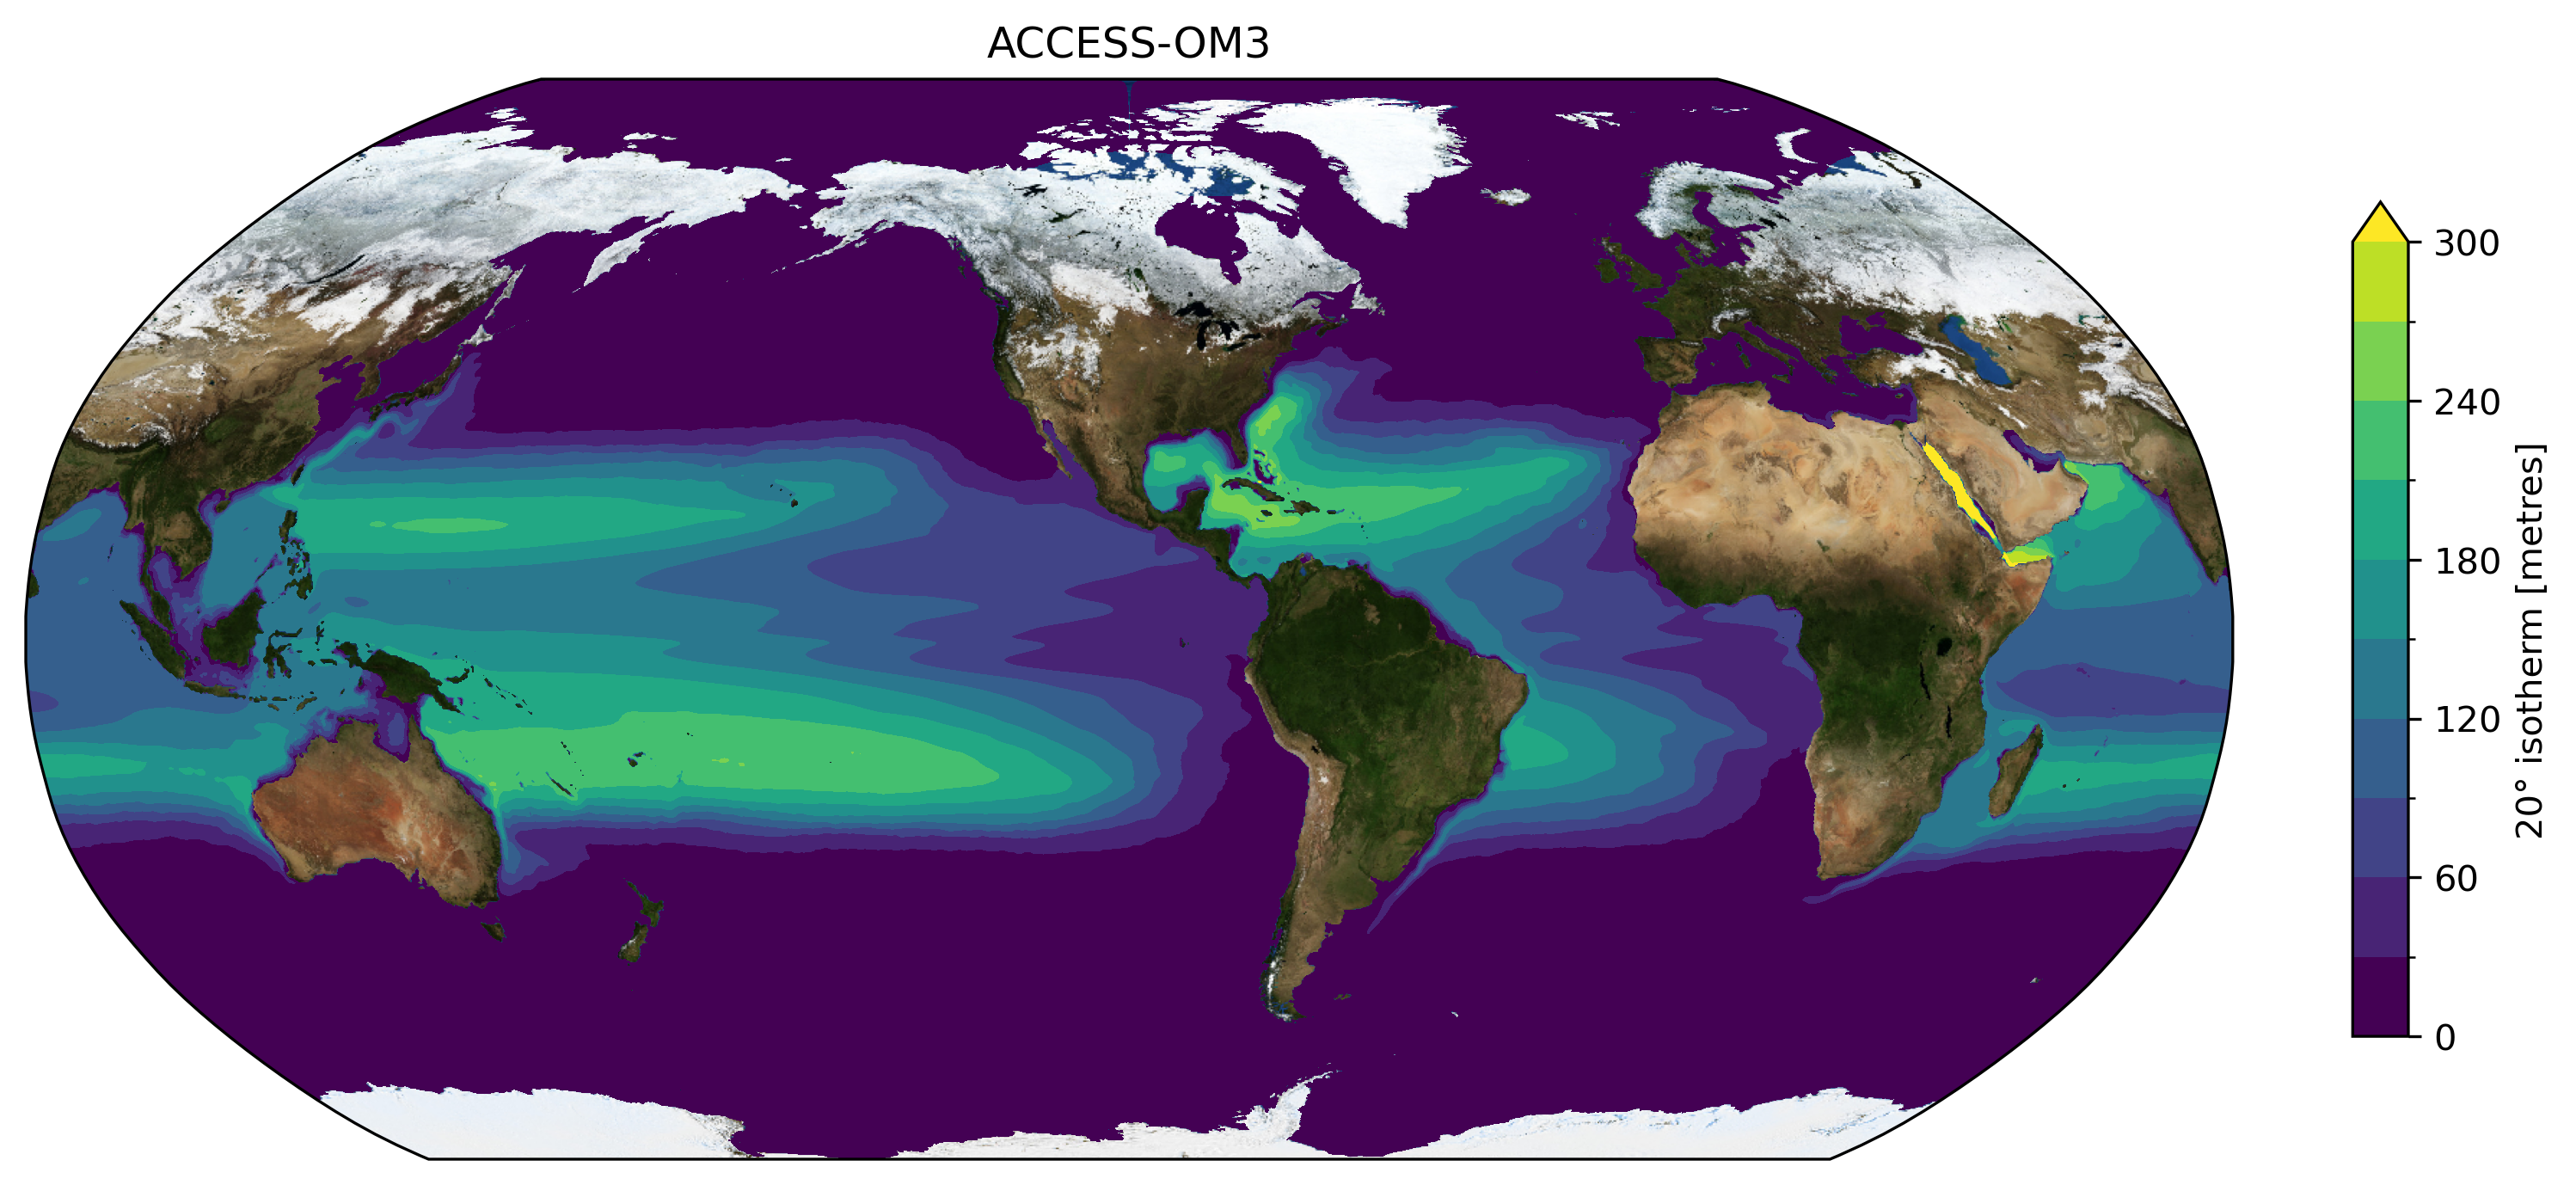

In [17]:
plot(annual_mean_z20,vmin=0,vmax=300,levels=11)
plt.title('ACCESS-OM3')

## Attempt to repeat for WOA13

In [18]:
maybe_relevant_files = (
'woa13_decav_t00_04v2.nc',
'woa13_decav_t01_04v2.nc',
'woa13_decav_t02_04v2.nc',
'woa13_decav_t03_04v2.nc',
'woa13_decav_t04_04v2.nc',
'woa13_decav_t05_04v2.nc',
'woa13_decav_t06_04v2.nc',
'woa13_decav_t07_04v2.nc',
'woa13_decav_t08_04v2.nc',
'woa13_decav_t09_04v2.nc',
'woa13_decav_t10_04v2.nc',
'woa13_decav_t11_04v2.nc',
'woa13_decav_t12_04v2.nc',
'woa13_decav_t13_04v2.nc',
'woa13_decav_t14_04v2.nc',
'woa13_decav_t15_04v2.nc',
'woa13_decav_t16_04v2.nc',
                       )

woa13_t = xr.open_mfdataset(['/g/data/ik11/inputs/WOA13v2/averaged_decades/'+f for f in maybe_relevant_files],
                          decode_times=False,
                            coords='minimal',
                            compat='override',
                         )

In [19]:
woa13_z20 = interpolate_isotherm_depth(woa13_t.t_an.mean('time'),target_temp=20,depth_name='depth')

In [20]:
woa13_z20.attrs['long_name'] = '20° isotherm'
woa13_z20.attrs['units'] = 'metres'

Text(0.5, 1.0, 'WOA13 preliminary (file-reading is suss)')

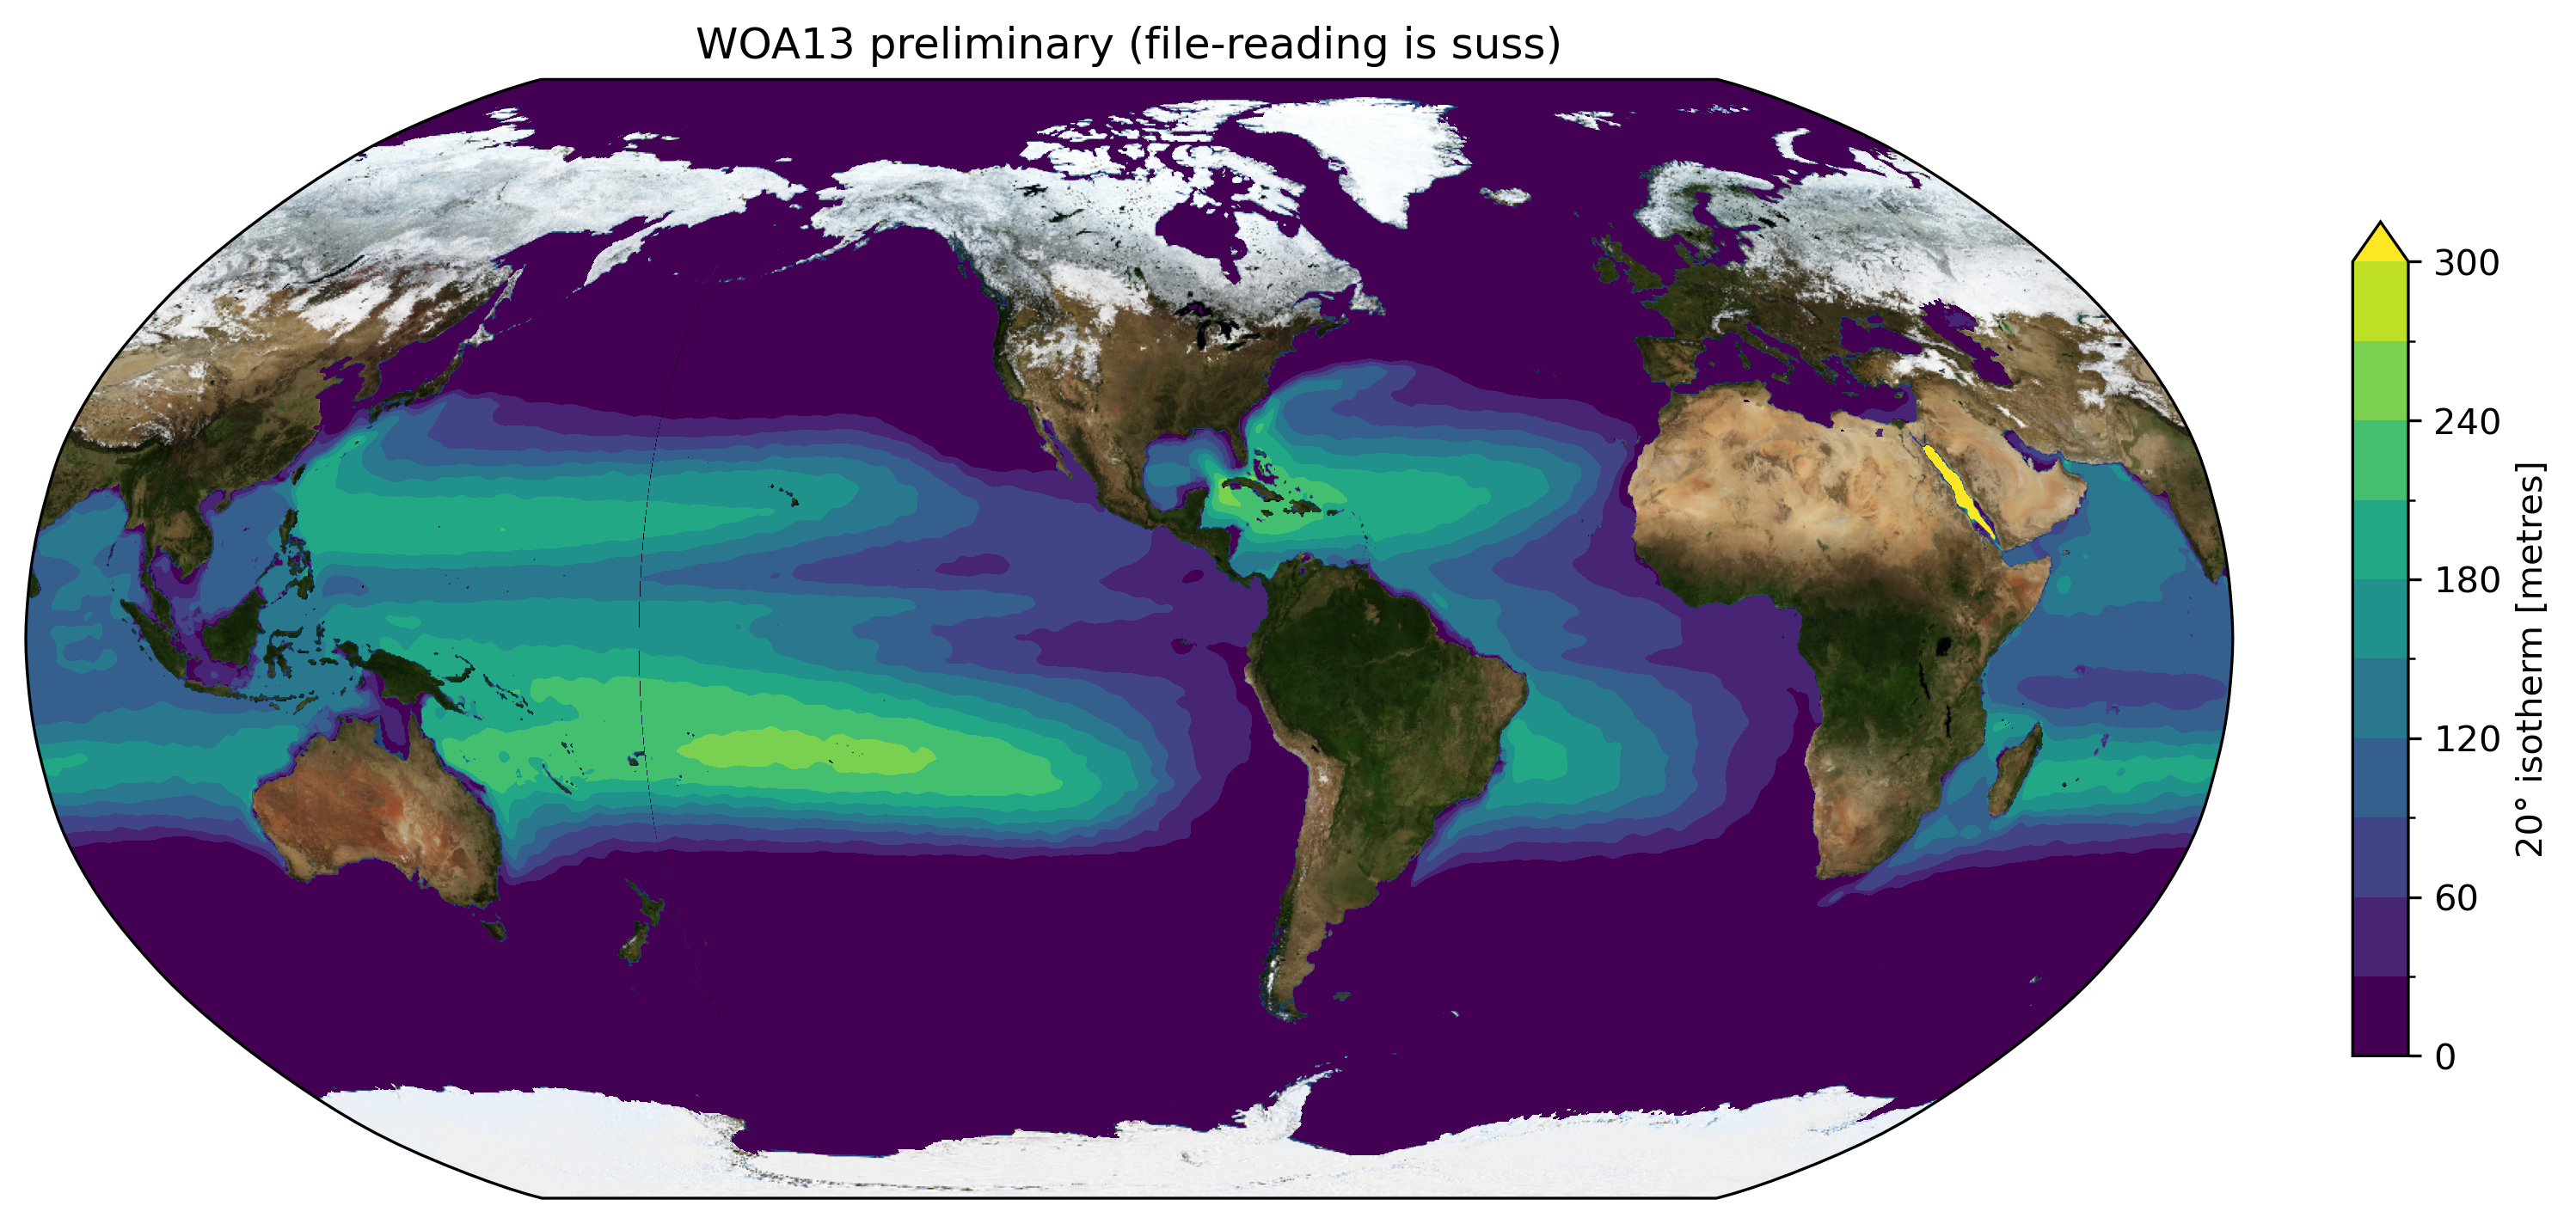

In [21]:
plot(woa13_z20.rename({'lat':'yh','lon':'xh'}),levels=11,vmin=0,vmax=300)
plt.title('WOA13 preliminary (file-reading is suss)')